<a href="https://colab.research.google.com/github/abshilpa/Chronic-Kidney-Disease-Data-Science-Project/blob/main/MSC_Final_project_CKD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MSC Data Science Final Project on Chronic Kidney Disease by Abbugari Dhanalakshmi Shilpa

## Chronic Kidney Disease Prediction Overview

This project is focused on predicting chronic kidney disease (CKD) by analyzing essential medical parameters,including Specific Gravity, Hypertension, Hemoglobin, Diabetes Mellitus, Albumin, Appetite, Red Blood Cell Count, Pus Cell, and more.
By utilizing advanced machine learning models, the system delivers precise predictions to support healthcare professionals in early diagnosis and informed decision-making, ultimately enhancing patient outcomes.

## Importing Required Libraries

In [60]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_recall_curve,
                             classification_report, ConfusionMatrixDisplay, accuracy_score)
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import joblib
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score


# Set a seed for reproducibility
SEED = 42
np.random.seed(SEED)


## Data Loading and Overview

Raw Dataset of CKD :
    id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns]

 CKD Dataset Info:

<class 'pandas.core.frame.D

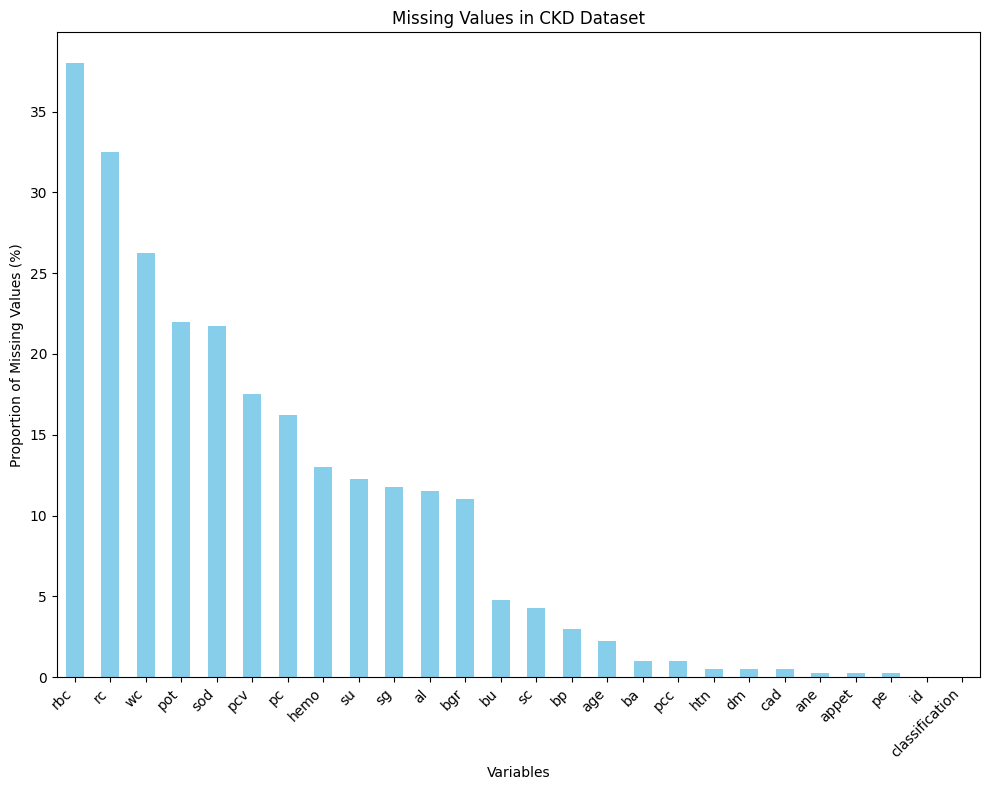

In [65]:
def load_CKDdata(file_path):
    """
    Loading the dataset and displaying basic information such as
    the few rows of dataset's, info, and missing values summary.

    Parameters:
    file_path (str): Path of the CKD Raw dataset file from Github.

    Returns:
    pd.DataFrame: Loaded CKD dataset.
    """
    CKD_data = pd.read_csv(file_path)
    print("Raw Dataset of CKD :\n", CKD_data.head())
    print("\n CKD Dataset Info:\n")
    print(CKD_data.info())
    print(CKD_data.describe())
    print("\nMissing Values in CKD data set:\n", CKD_data.isnull().sum())
    # Classifying columns : categorical columns and numerical columns
    cat_cols = [col for col in CKD_data.columns if CKD_data[col].dtype=='object']
    num_cols = [col for col in CKD_data.columns if CKD_data[col].dtype!='object']

    # Displaying the  counts and names of the columns
    print(f"Count of categorical columns: {len(cat_cols)}")
    print("Categorical columns:", cat_cols)

    print(f"\nCount of numerical columns: {len(num_cols)}")
    print("Numerical columns:", num_cols)

    return CKD_data

def plot_missing_values_bar(data):
    """
    Plotting a bar chart to visualize missing values proportion in each column.

    Parameters:
    data (pd.DataFrame): The dataset to analyze.
    """
    missing_values = (data.isna().sum() / data.shape[0] * 100).sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    missing_values.plot(kind='bar', color='skyblue')
    plt.title('Missing Values in CKD Dataset')
    plt.xlabel('Variables')
    plt.ylabel('Proportion of Missing Values (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Replace 'file_path' with the actual location of your dataset
file_path = "https://raw.githubusercontent.com/abshilpa/Chronic-Kidney-Disease-Data-Science-Project/refs/heads/main/kidney_disease.csv"
CKD_data = load_CKDdata(file_path)
plot_missing_values_bar(CKD_data)


## Data Preprocessing

In [66]:

def treat_outliers(data, numeric_cols, iqr_multiplier=1.5):
    """
    Treat outliers using the IQR method by capping extreme values to the bounds.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric columns to treat for outliers.
    iqr_multiplier (float): Multiplier for the IQR to define outlier thresholds.

    Returns:
    pd.DataFrame: Dataset with treated outliers.
    """
    data_treated = data.copy()

    print("Treating outliers...")
    for col in numeric_cols:
        Q1 = data_treated[col].quantile(0.25)
        Q3 = data_treated[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        print(f"{col}: Lower bound = {lower_bound}, Upper bound = {upper_bound}")

        # Cap outliers
        data_treated[col] = data_treated[col].clip(lower=lower_bound, upper=upper_bound)

    return data_treated

def plot_outliers(data, numeric_cols, title="Box Plot of Numeric Features"):
    """
    Plot box plots for numeric features.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric column names.
    title (str): Title for the plot.
    """
    num_cols = len(numeric_cols)
    rows = (num_cols // 3) + (num_cols % 3 > 0)

    plt.figure(figsize=(15, rows * 4))
    for idx, col in enumerate(numeric_cols):
        plt.subplot(rows, 3, idx + 1)
        sns.boxplot(y=data[col], color="skyblue")
        plt.title(f"Box Plot of {col}")
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def preprocess_data(CKD_data):
    """
    Preprocess the CKD dataset:
    - Rename columns.
    - Handle missing values.
    - Treat outliers.
    - Encode categorical variables.
    - Scale numerical features.
    - Classify columns into categorical and numerical types.

    Parameters:
    CKD_data (pd.DataFrame): The dataset to preprocess.

    Returns:
    pd.DataFrame: Preprocessed dataset.
    """
    # Step 1: Rename columns to standard names
    CKD_data.columns = [
        'ID', 'Age', 'Blood Pressure', 'Specific Gravity', 'Albumin', 'Sugar',
        'Red Blood Cells', 'Pus Cell', 'Pus Cell Clumps', 'Bacteria',
        'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Sodium',
        'Potassium', 'Hemoglobin', 'Packed Cell Volume', 'White Blood Cell Count',
        'Red Blood Cell Count', 'Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
        'Appetite', 'Pedal Edema', 'Anemia', 'Classification'
    ]
    print("Updated DataFrame with new column names:")
    print(CKD_data.head())

    # Step 2: Handle non-standard values
    CKD_data.replace({'\t?': np.nan}, inplace=True)
    CKD_data['Classification'] = CKD_data['Classification'].str.replace('ckd\t', 'ckd', regex=False)
    CKD_data['Diabetes Mellitus'].replace({'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'}, inplace=True)
    CKD_data['Coronary Artery Disease'].replace({'\tno': 'no'}, inplace=True)
    print("Unique values in 'Classification' after replacement:")
    print(CKD_data['Classification'].unique())
    print("Unique values in 'Diabetes Mellitus' after replacement:")
    print(CKD_data['Diabetes Mellitus'].unique())
    print("Unique values in 'Coronary Artery Disease' after replacement:")
    print(CKD_data['Coronary Artery Disease'].unique())


    # Step 3: Handle missing values
    cat_cols = [col for col in CKD_data.columns if CKD_data[col].dtype == 'object']
    for col in cat_cols:
        CKD_data[col].fillna(CKD_data[col].mode()[0], inplace=True)

    num_cols = [col for col in CKD_data.columns if CKD_data[col].dtype in ['float64', 'int64']]
    for col in num_cols:
        CKD_data[col].fillna(CKD_data[col].median(), inplace=True)

    print("\nMissing values after cleaning:")
    print(CKD_data.isnull().sum())

    # Step 4: Plot outliers before treatment
    print("Plotting outliers before treatment...")
    plot_outliers(CKD_data, num_cols, title="Outliers Before Treatment")

    # Step 5: Treat outliers
    CKD_data = treat_outliers(CKD_data, num_cols)

    # Step 6: Plot outliers after treatment
    print("Plotting outliers after treatment...")
    plot_outliers(CKD_data, num_cols, title="Outliers After Treatment")

    # Step 7: Encode categorical variables
    for col in cat_cols:
        CKD_data[col] = LabelEncoder().fit_transform(CKD_data[col])

    # Step 8: Scale numeric features
    scaler = StandardScaler()
    CKD_data[num_cols] = scaler.fit_transform(CKD_data[num_cols])

    print("\nData after encoding and scaling:")
    print(CKD_data.head())

    return CKD_data


Updated DataFrame with new column names:
   ID   Age  Blood Pressure  Specific Gravity  Albumin  Sugar Red Blood Cells  \
0   0  48.0            80.0             1.020      1.0    0.0             NaN   
1   1   7.0            50.0             1.020      4.0    0.0             NaN   
2   2  62.0            80.0             1.010      2.0    3.0          normal   
3   3  48.0            70.0             1.005      4.0    0.0          normal   
4   4  51.0            80.0             1.010      2.0    0.0          normal   

   Pus Cell Pus Cell Clumps    Bacteria  ...  Packed Cell Volume  \
0    normal      notpresent  notpresent  ...                  44   
1    normal      notpresent  notpresent  ...                  38   
2    normal      notpresent  notpresent  ...                  31   
3  abnormal         present  notpresent  ...                  32   
4    normal      notpresent  notpresent  ...                  35   

   White Blood Cell Count  Red Blood Cell Count  Hypertension  

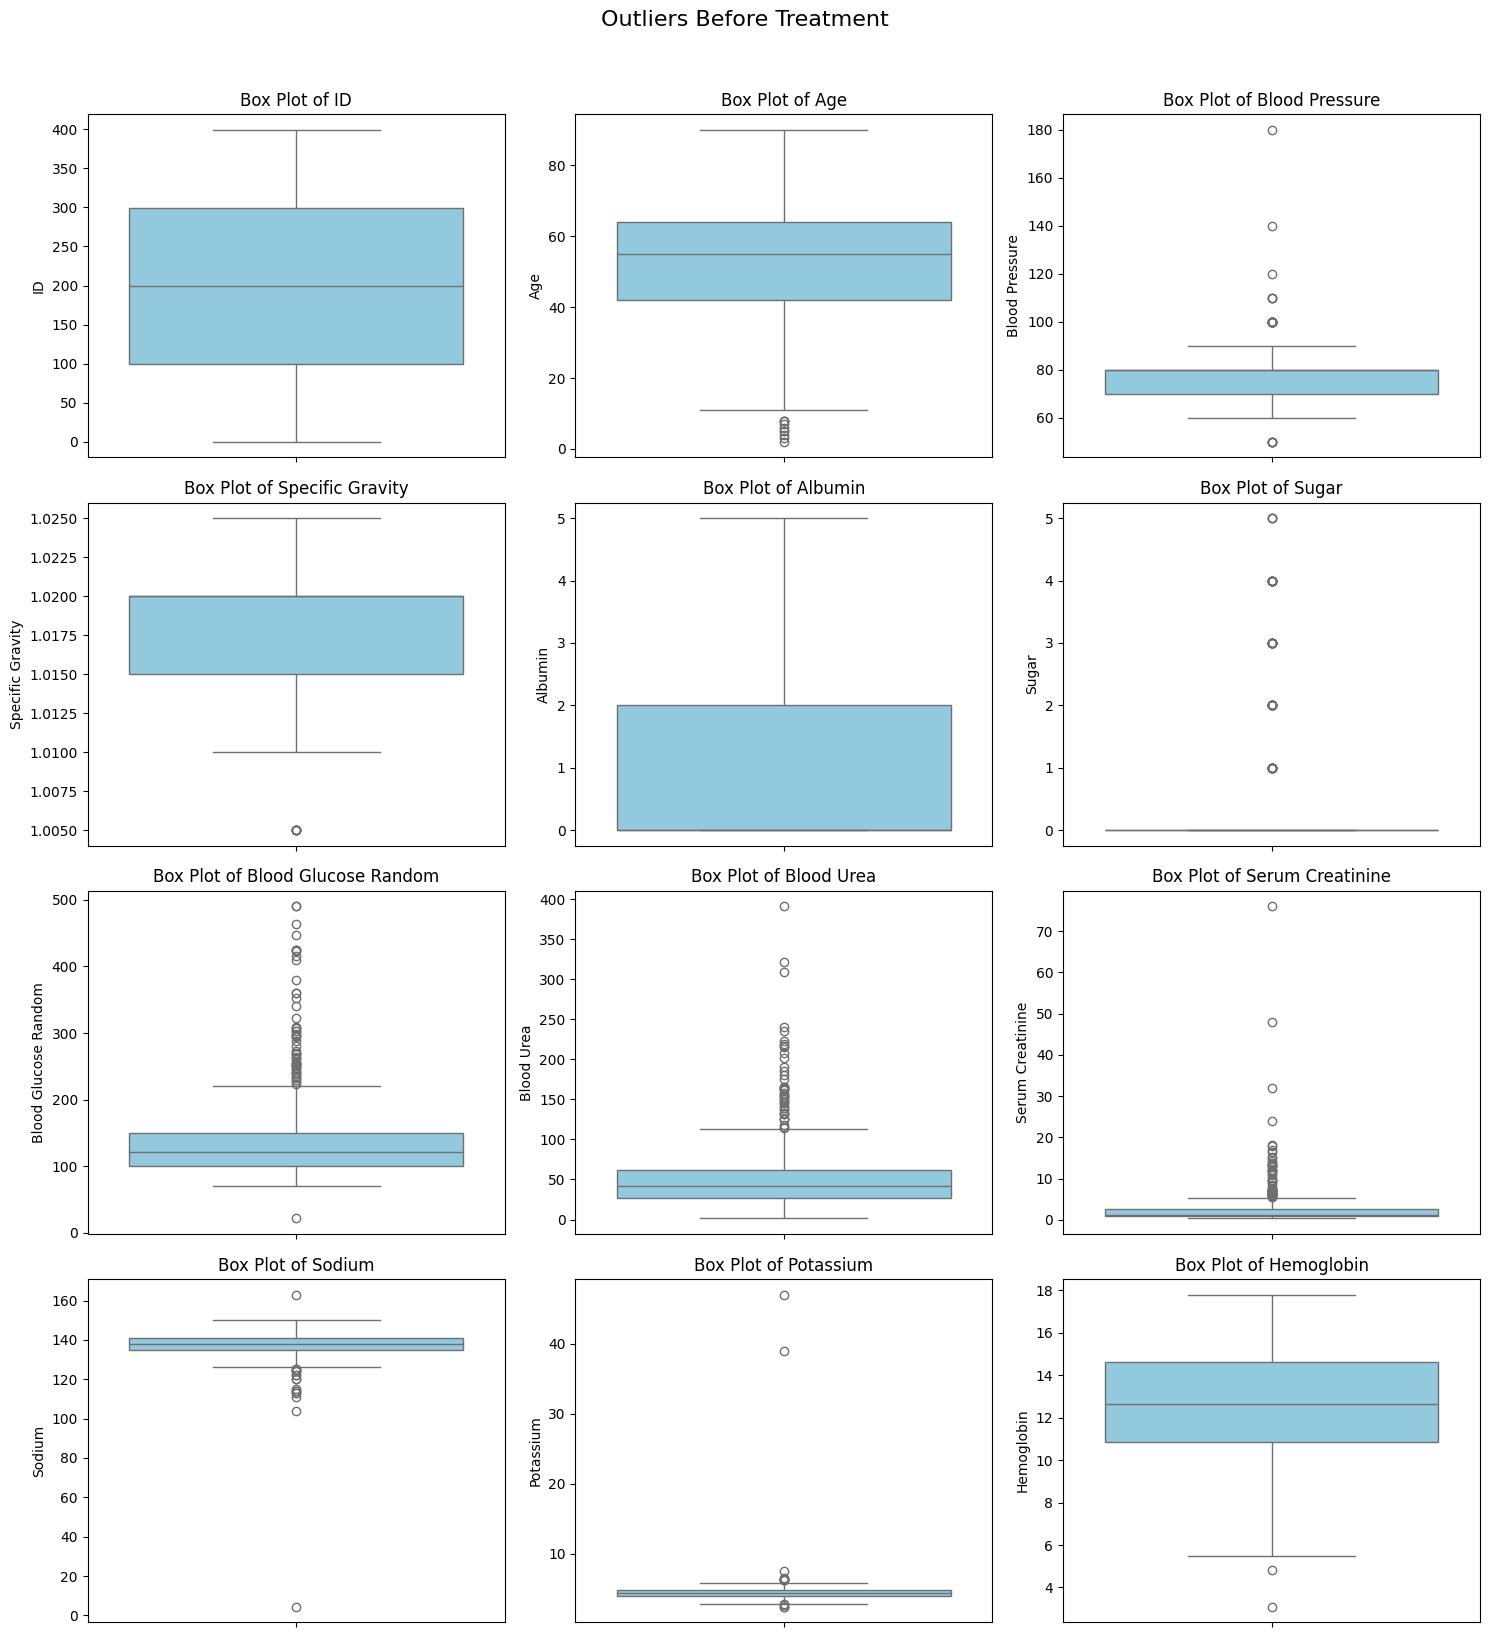

Treating outliers...
ID: Lower bound = -199.5, Upper bound = 598.5
Age: Lower bound = 9.0, Upper bound = 97.0
Blood Pressure: Lower bound = 55.0, Upper bound = 95.0
Specific Gravity: Lower bound = 1.0074999999999998, Upper bound = 1.0275000000000003
Albumin: Lower bound = -3.0, Upper bound = 5.0
Sugar: Lower bound = 0.0, Upper bound = 0.0
Blood Glucose Random: Lower bound = 27.5, Upper bound = 223.5
Blood Urea: Lower bound = -25.125, Upper bound = 113.875
Serum Creatinine: Lower bound = -1.8375000000000004, Upper bound = 5.4625
Sodium: Lower bound = 126.0, Upper bound = 150.0
Potassium: Lower bound = 2.8000000000000003, Upper bound = 6.0
Hemoglobin: Lower bound = 5.25, Upper bound = 20.25
Plotting outliers after treatment...


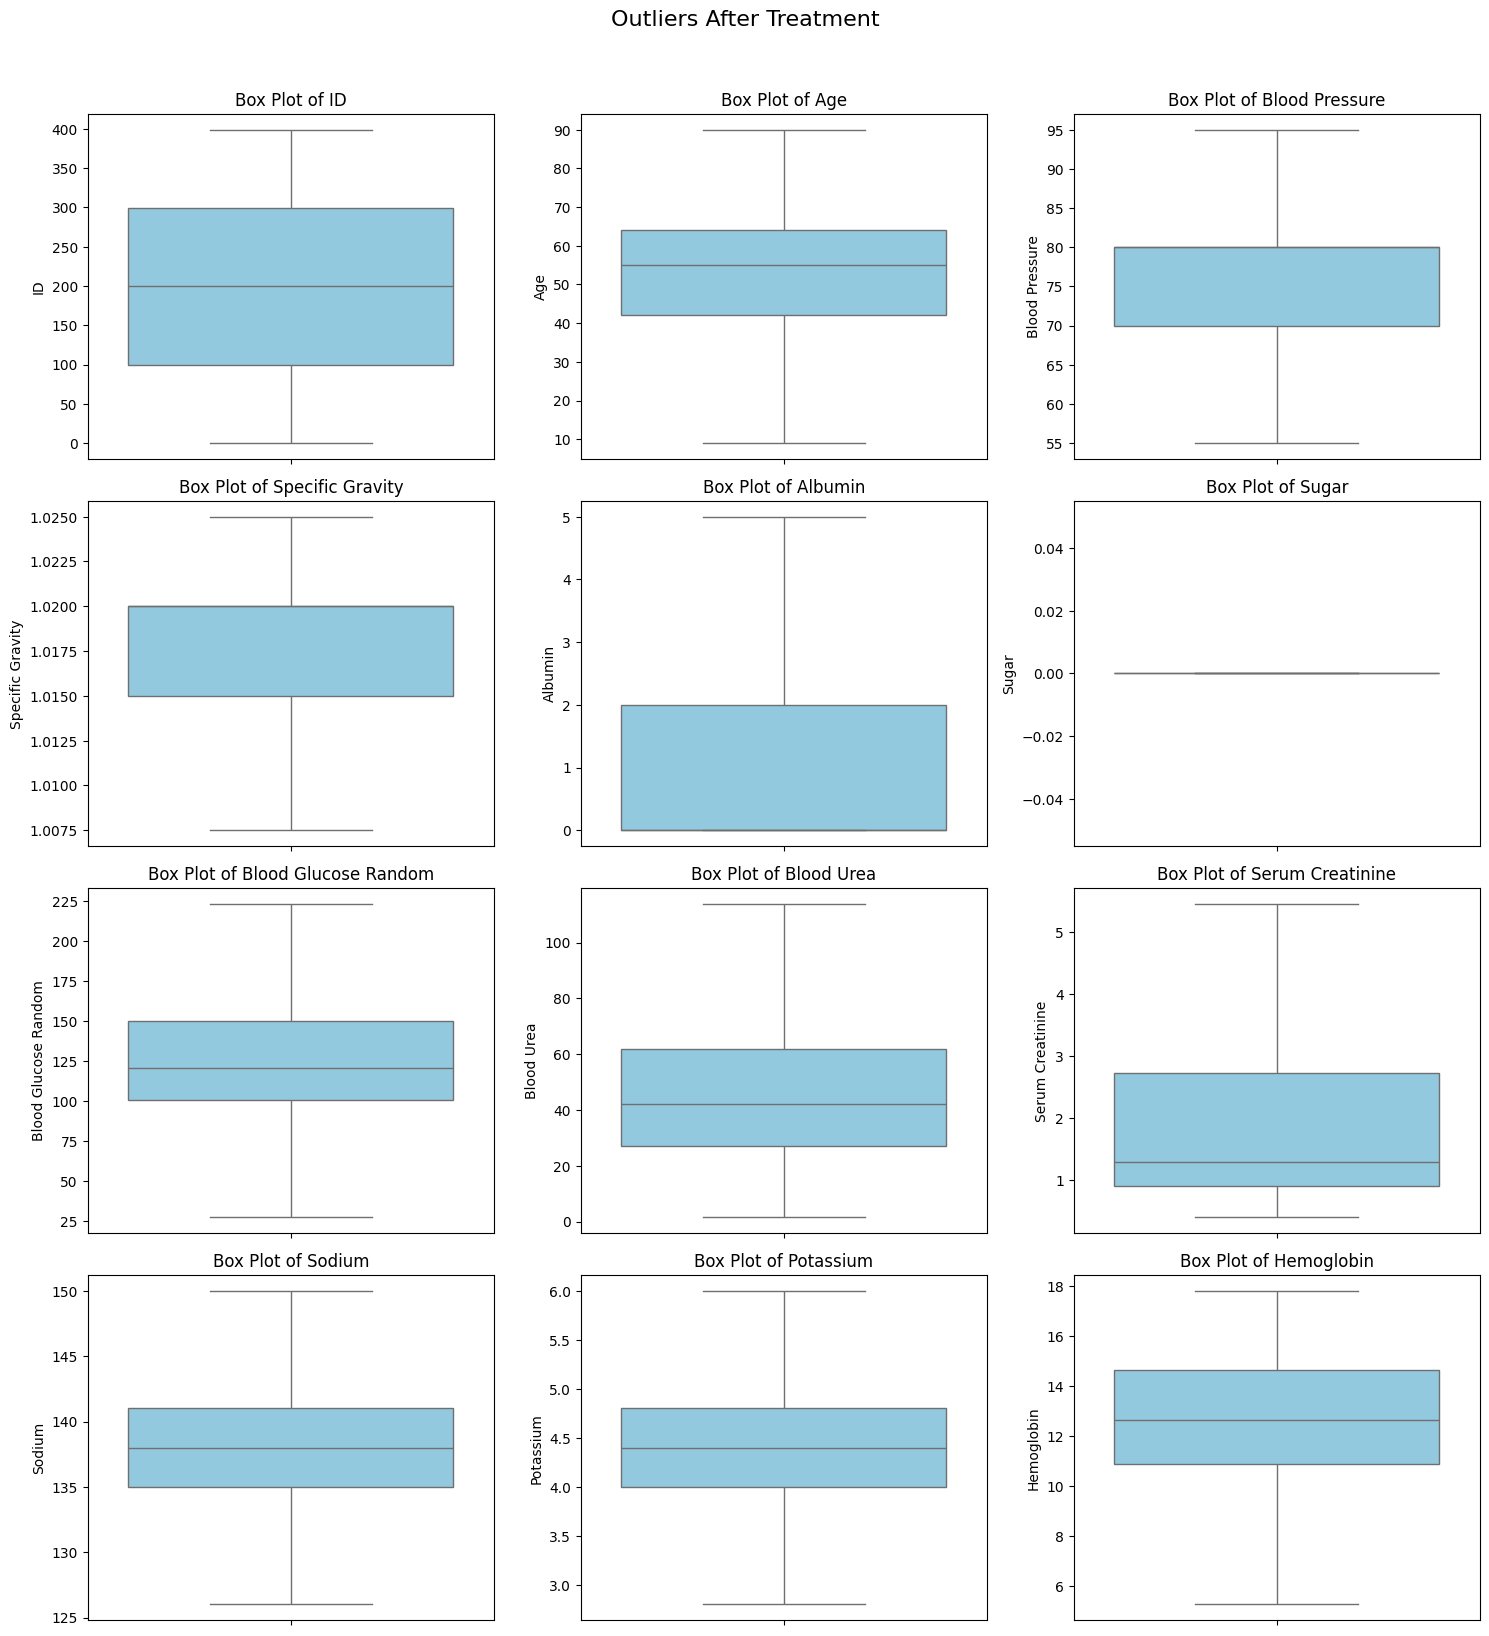


Data after encoding and scaling:
         ID       Age  Blood Pressure  Specific Gravity   Albumin  Sugar  \
0 -1.727726 -0.217955        0.381013          0.420662  0.076249    0.0   
1 -1.719066 -2.548388       -1.900504          0.420662  2.363728    0.0   
2 -1.710406  0.618610        0.381013         -1.454156  0.838742    0.0   
3 -1.701745 -0.217955       -0.531594         -1.922860  2.363728    0.0   
4 -1.693085 -0.038691        0.381013         -1.454156  0.838742    0.0   

   Red Blood Cells  Pus Cell  Pus Cell Clumps  Bacteria  ...  \
0                1         1                0         0  ...   
1                1         1                0         0  ...   
2                1         1                0         0  ...   
3                1         0                1         0  ...   
4                1         1                0         0  ...   

   Packed Cell Volume  White Blood Cell Count  Red Blood Cell Count  \
0                  31                      71        

In [67]:
# Assuming your dataset is loaded into CKD_data
processed_data = preprocess_data(CKD_data)

## Exploratory Data Analysis (EDA)

Plotting numeric feature distributions...


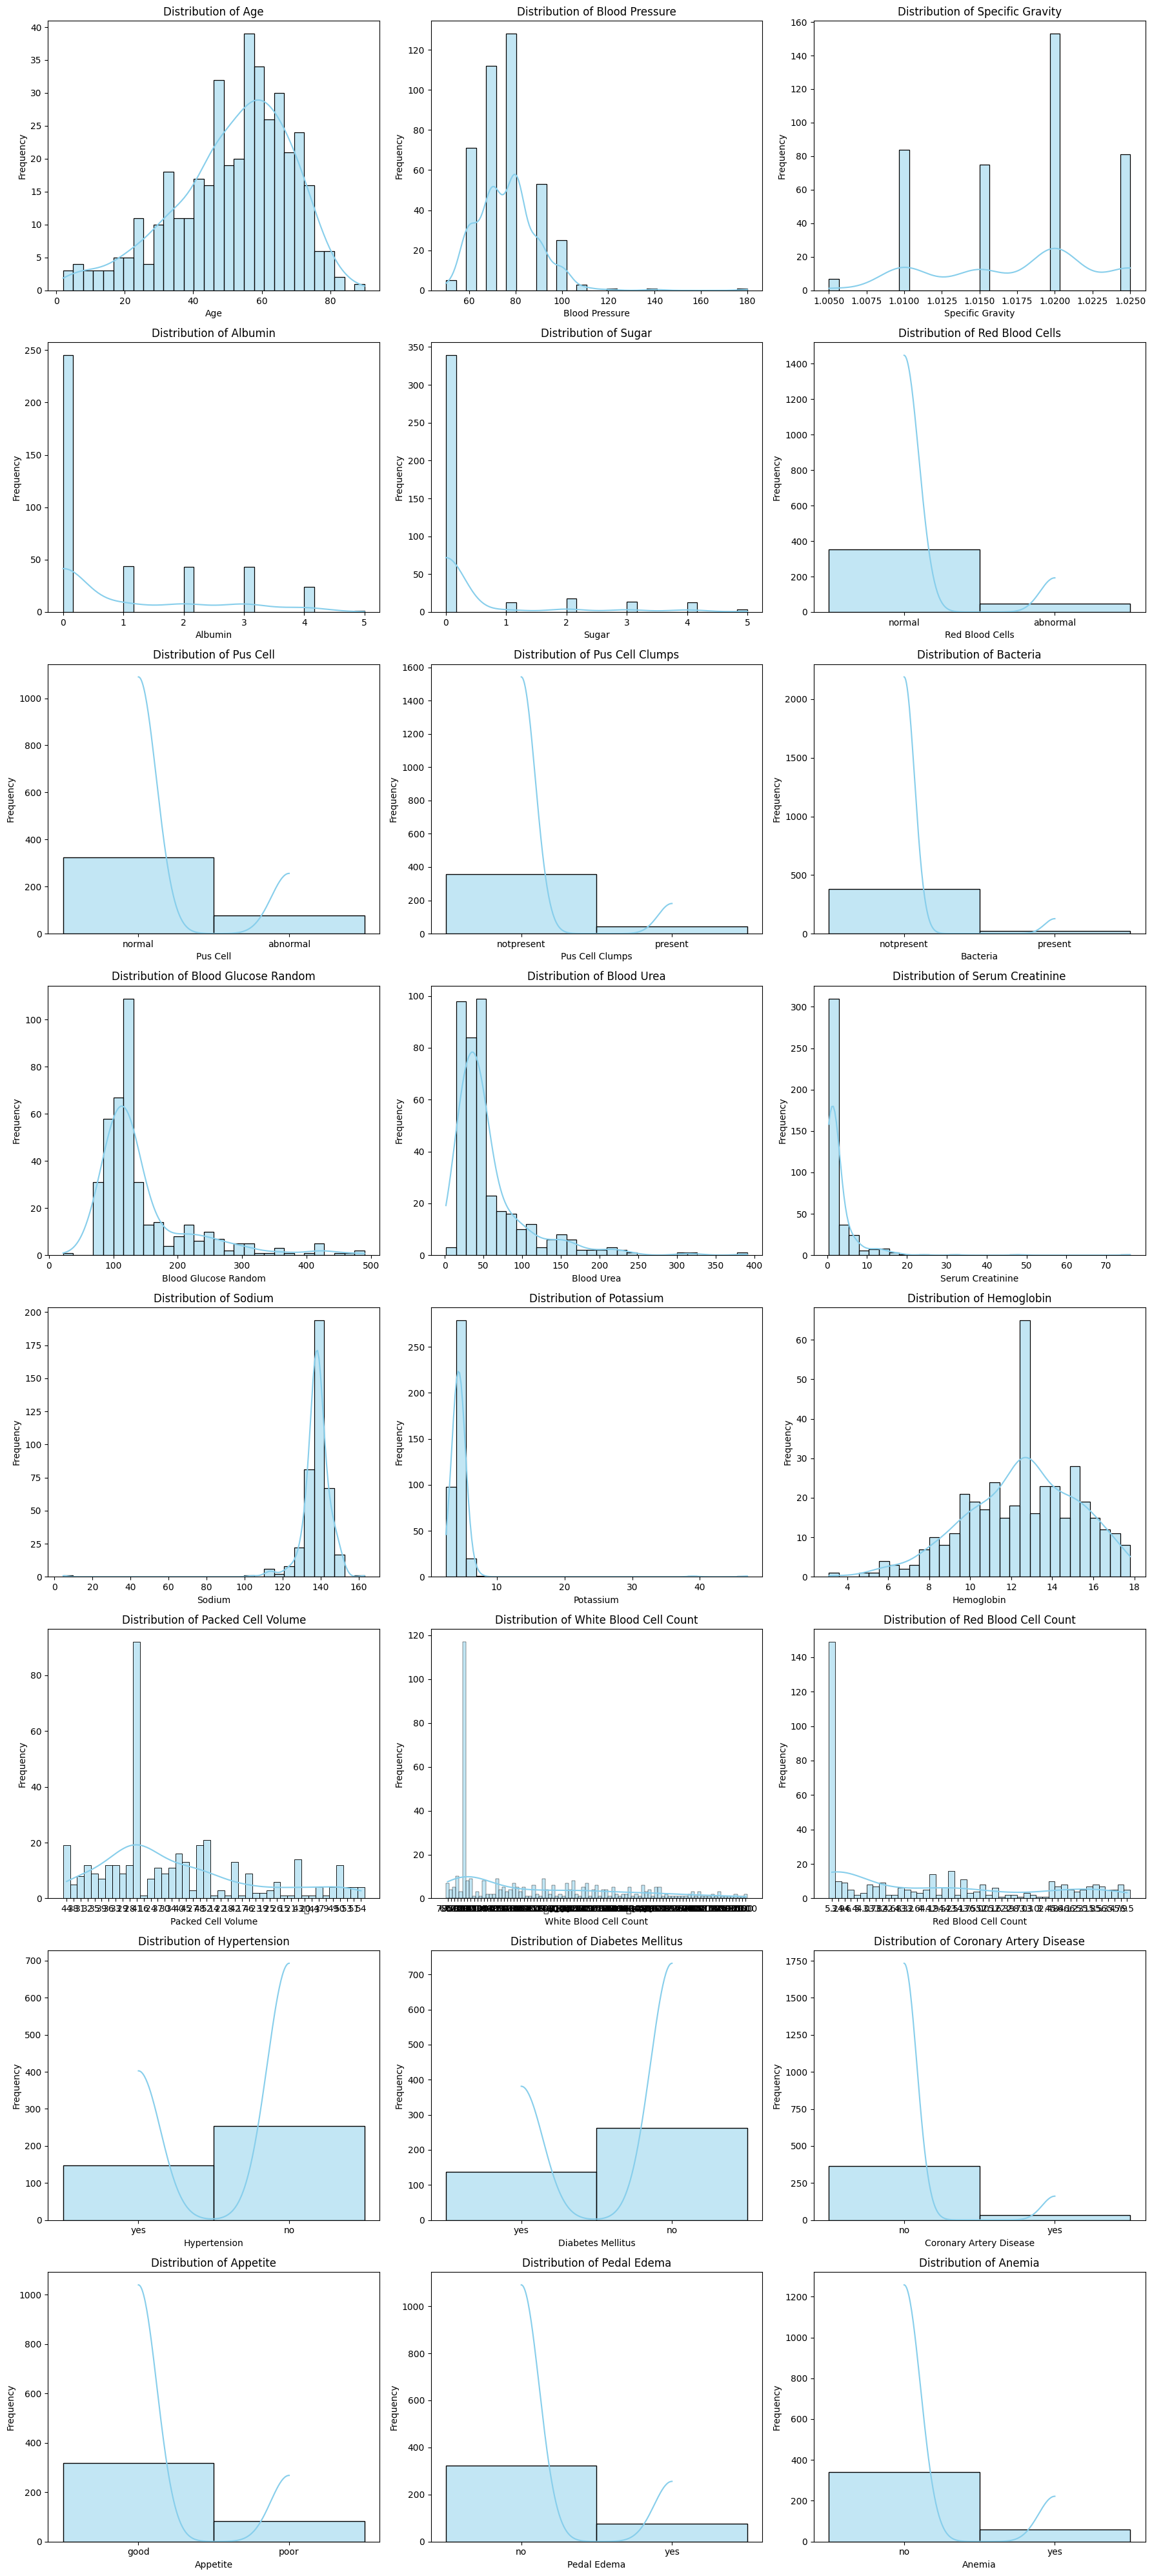

Plotting categorical feature counts...


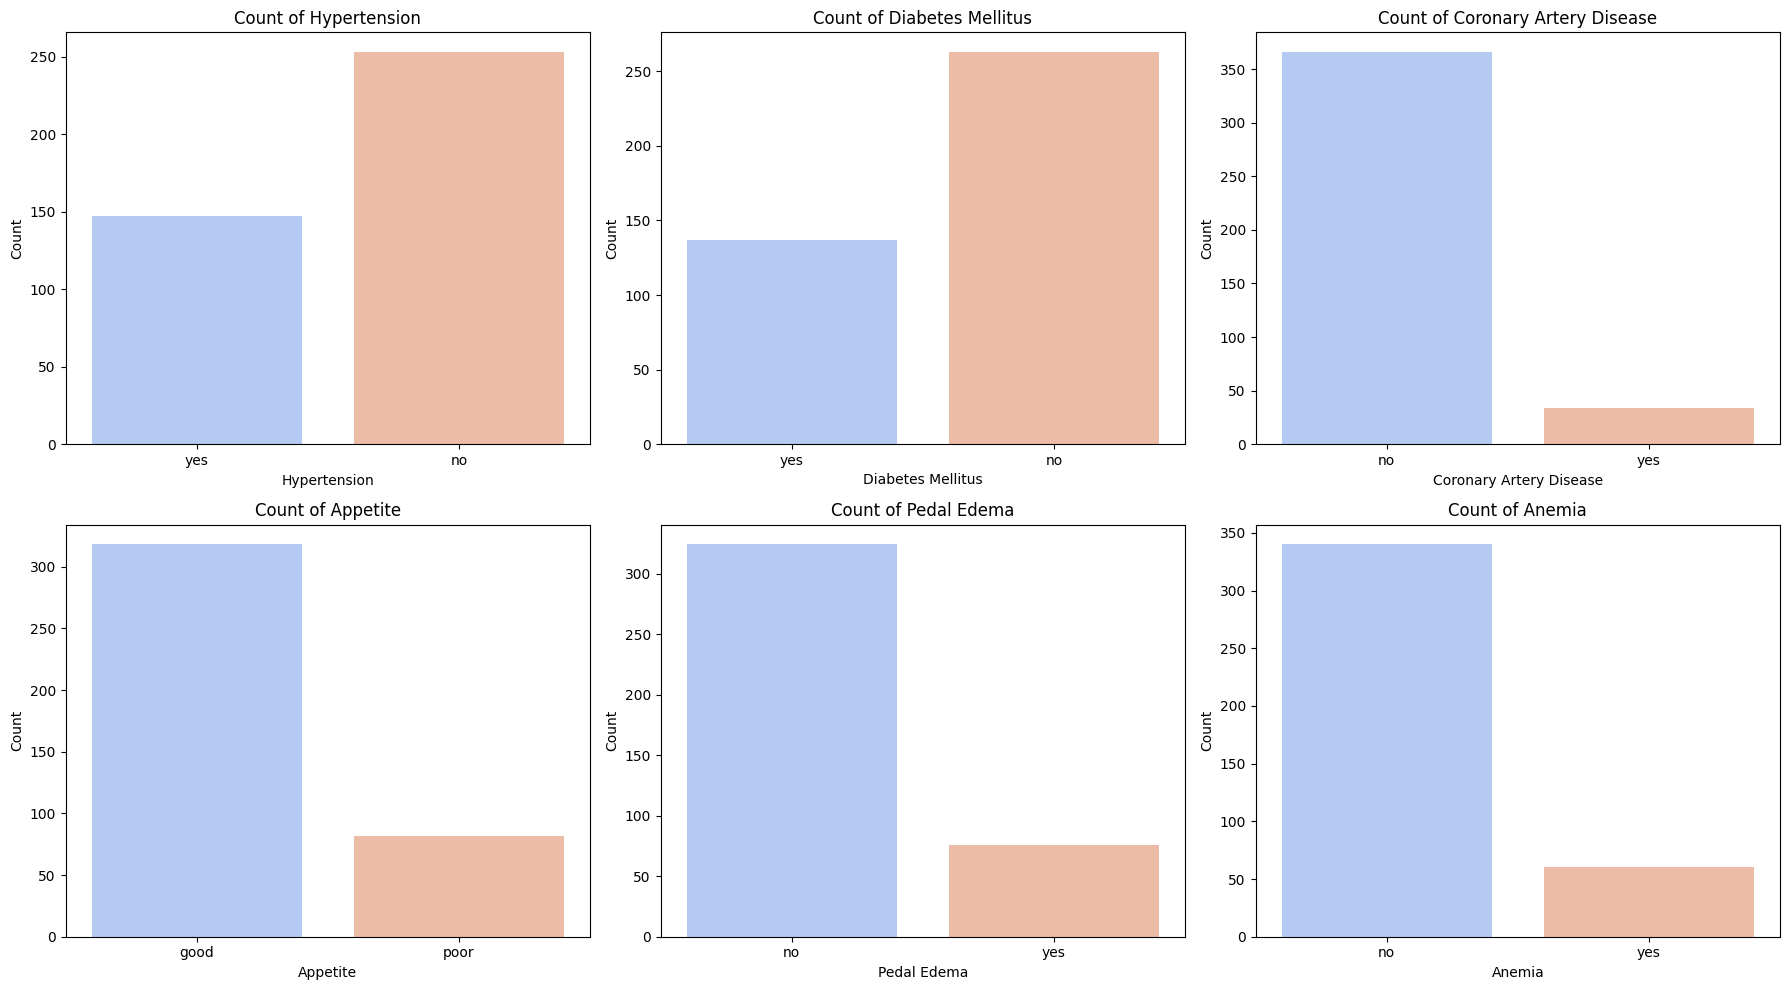

Plotting correlation heatmap...


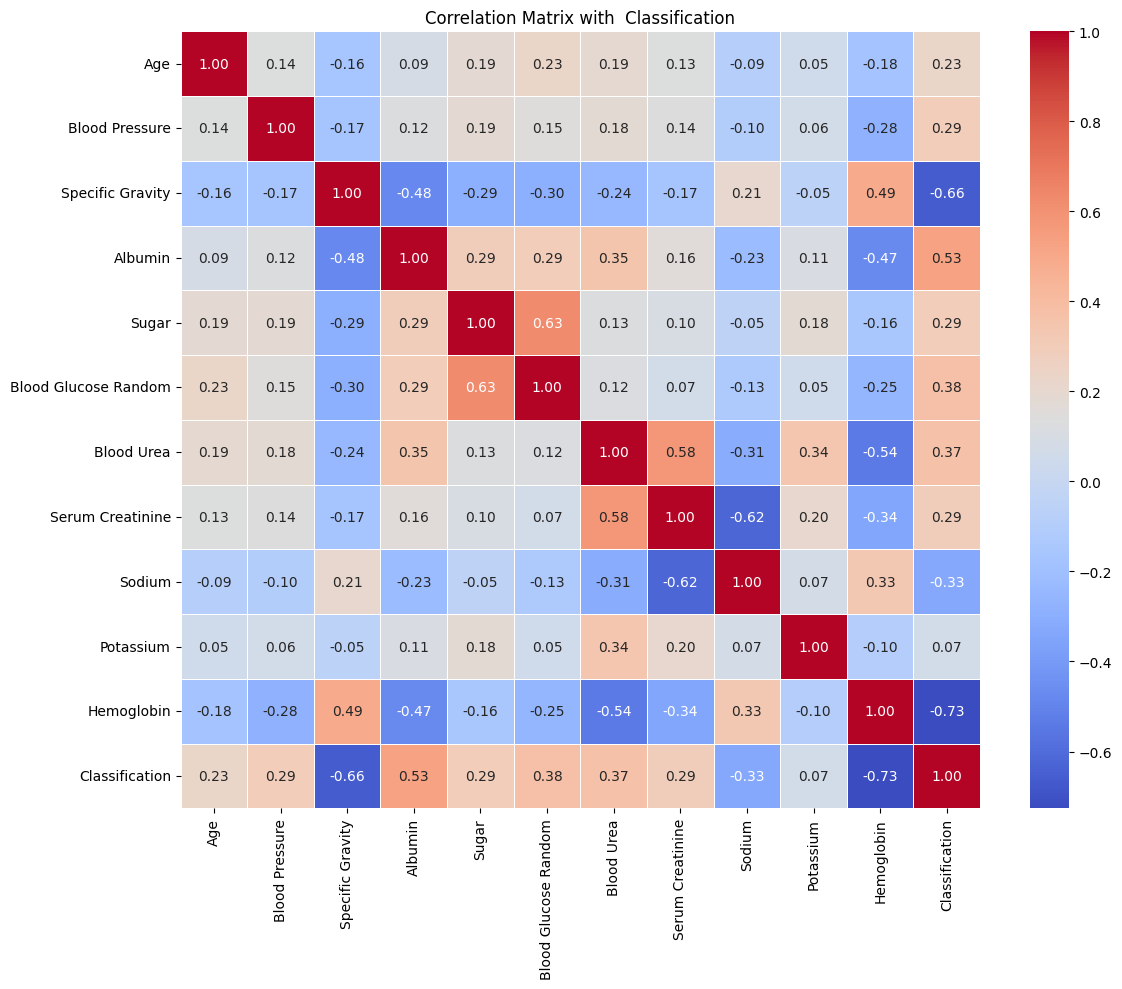

In [68]:
# Exploratory Data Analysis (EDA)
def plot_distributions(data, numeric_cols):
    """
    Plot distributions of numeric features.

    Parameters:
    data (pd.DataFrame): The dataset.
    numeric_cols (list): List of numeric column names.
    """
    num_plots = len(numeric_cols)
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(data[col], kde=True, bins=30, color='skyblue', ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_categorical_counts(data, categorical_cols):
    """
    Plot count plots for categorical variables.

    Parameters:
    data (pd.DataFrame): The dataset.
    categorical_cols (list): List of categorical column names.
    """
    num_plots = len(categorical_cols)
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=data[col], palette="coolwarm", ax=axes[i])
        axes[i].set_title(f"Count of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(data):
    """
    Plot a correlation heatmap for the dataset including the 'Classification' column.

    Parameters:
    data (pd.DataFrame): The dataset.
    """
    # Encode 'Classification' if not numeric
    if data['Classification'].dtype not in ['float64', 'int64']:
        data['Classification'] = data['Classification'].map({'ckd': 1, 'notckd': 0})

    # Exclude the 'ID' column and select only numeric columns
    numeric_data = data.drop(columns=['ID']).select_dtypes(include=['float64', 'int64'])

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix with  Classification")
    plt.tight_layout()
    plt.show()


# Perform EDA
numeric_cols = [col for col in X_for_vif.columns if col != 'ID']  # Exclude 'ID'
categorical_cols = ['Hypertension', 'Diabetes Mellitus', 'Coronary Artery Disease',
                    'Appetite', 'Pedal Edema', 'Anemia']

print("Plotting numeric feature distributions...")
plot_distributions(CKD_data, numeric_cols)

print("Plotting categorical feature counts...")
plot_categorical_counts(CKD_data, categorical_cols)

print("Plotting correlation heatmap...")
plot_correlation_heatmap(CKD_data)


Variance Inflation Factor (VIF):
                 Feature           VIF
0                  const  53937.041163
1                    Age      1.107525
2         Blood Pressure      1.121064
3       Specific Gravity      1.545864
4                Albumin      1.567571
5                  Sugar      1.818931
6   Blood Glucose Random      1.797435
7             Blood Urea      2.181824
8       Serum Creatinine      2.397746
9                 Sodium      1.887444
10             Potassium      1.241974
11            Hemoglobin      2.000912


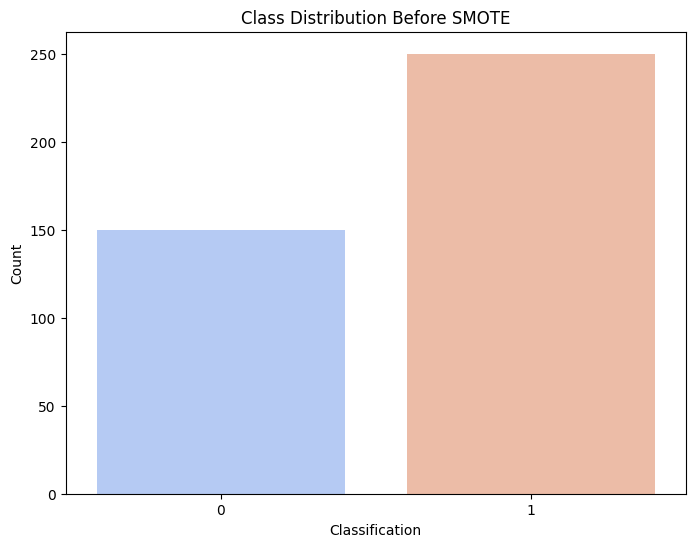

Class Imbalance:
Classification
1    250
0    150
Name: count, dtype: int64


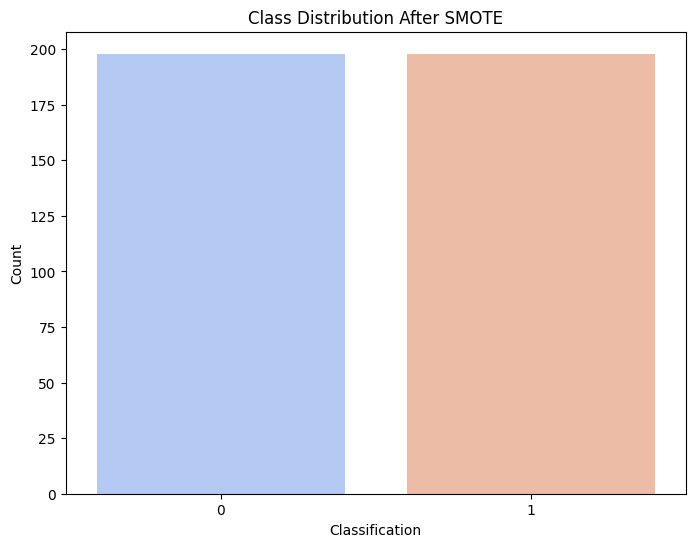

Class Distribution After SMOTE:
Classification
1    198
0    198
Name: count, dtype: int64


In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def calculate_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for the features.

    Parameters:
    X (pd.DataFrame): Dataset for which to calculate VIF.

    Returns:
    pd.DataFrame: DataFrame containing features and their VIF values.
    """
    # Ensure input only contains numerical data
    X_numeric = X.select_dtypes(include=['float64', 'int64'])
    X_numeric = add_constant(X_numeric)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_numeric.columns
    vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
    print("Variance Inflation Factor (VIF):")
    print(vif_data)
    return vif_data



def apply_smote(X, y):
    """
    Apply SMOTE to handle class imbalance.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.

    Returns:
    Tuple: Resampled features and target variable.
    """
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# After preprocessing numerical and categorical features

X_for_vif = CKD_data.drop(columns=['Classification', 'ID'])

# Calculate VIF (only numeric columns)
vif_data = calculate_vif(X_for_vif)



# Check for class imbalance in the target variable
# Class distribution before SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(data=CKD_data, x='Classification', palette='coolwarm')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

# Count of each class
class_counts = CKD_data['Classification'].value_counts()
print("Class Imbalance:")
print(class_counts)

# Step 3: Data Splitting and Balancing

# Ensure all features in X are numeric before SMOTE
X_numeric = X_for_vif.select_dtypes(include=['float64', 'int64'])
y = CKD_data['Classification']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training dataset
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)

# Class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled, palette='coolwarm')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.show()

print(f"Class Distribution After SMOTE:\n{pd.Series(y_train_resampled).value_counts()}")


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

def train_and_evaluate_models(X_train, X_test, y_train, y_test, models):
    """
    Train and evaluate multiple models.

    Parameters:
    X_train, X_test, y_train, y_test: Dataset splits
    models (dict): Dictionary of model names and initialized models

    Returns:
    None: Prints the evaluation results for each model.
    """
    for model_name, model in models.items():
        print(f"\nTraining and Evaluating: {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

# Call the function to train and evaluate the models
train_and_evaluate_models(X_train_resampled, X_test, y_train_resampled, y_test, models)



Training and Evaluating: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.98      0.98      0.98        52

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80

Confusion Matrix:
[[27  1]
 [ 1 51]]

Training and Evaluating: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

Confusion Matrix:
[[28  0]
 [ 1 51]]

Training and Evaluating: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.0

Evaluating: Logistic Regression


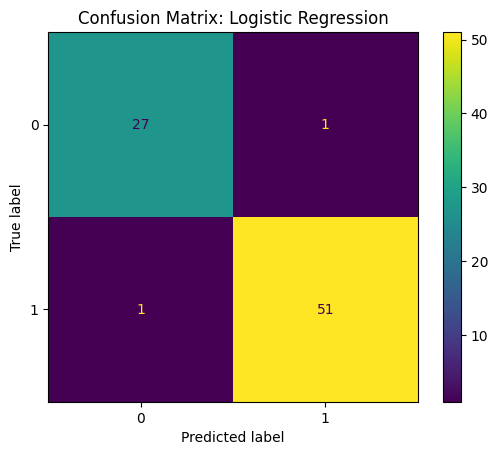

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.98      0.98      0.98        52

    accuracy                           0.97        80
   macro avg       0.97      0.97      0.97        80
weighted avg       0.97      0.97      0.97        80

Evaluating: Decision Tree


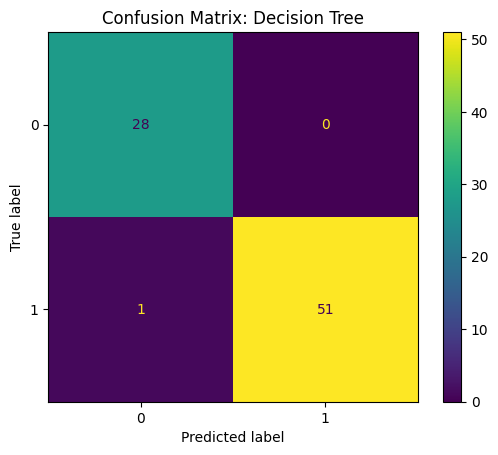

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

Evaluating: Random Forest


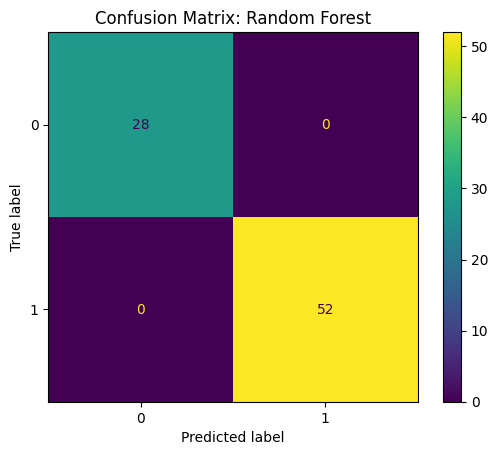

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        52

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Evaluating: SVM


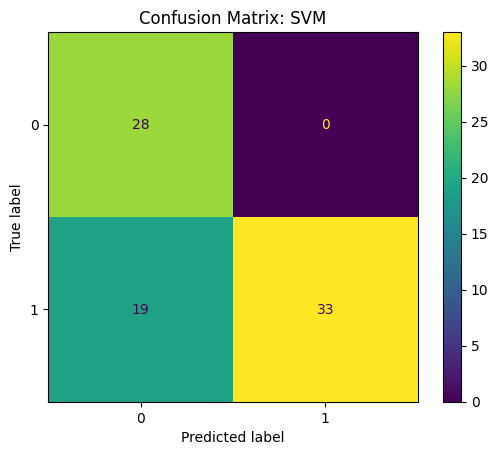

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        28
           1       1.00      0.63      0.78        52

    accuracy                           0.76        80
   macro avg       0.80      0.82      0.76        80
weighted avg       0.86      0.76      0.77        80



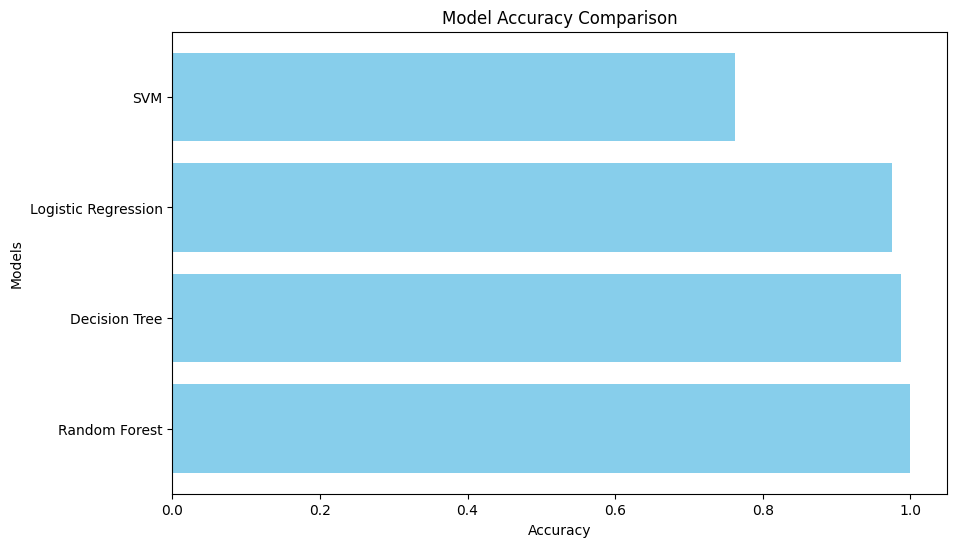

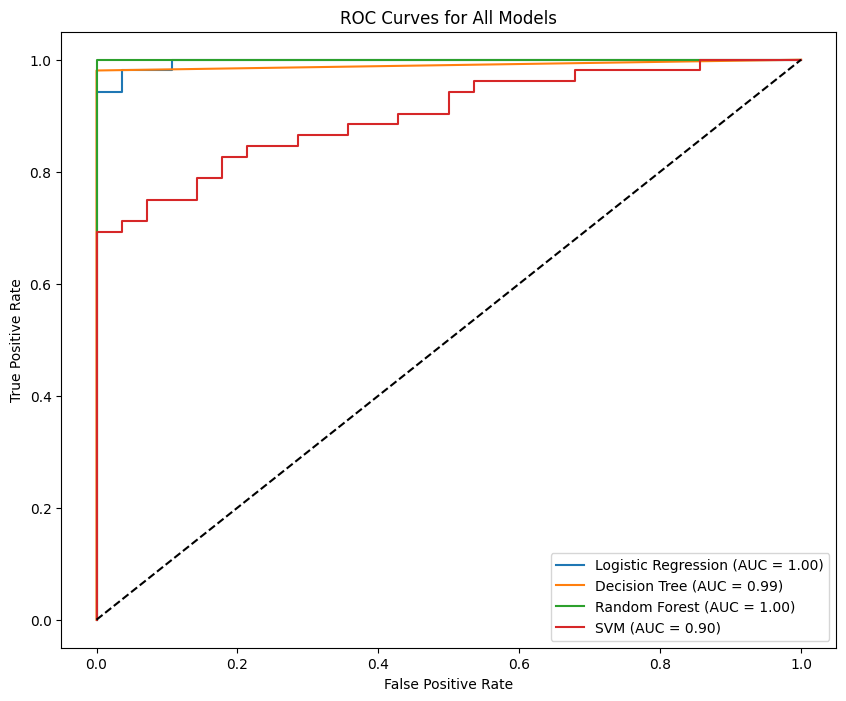

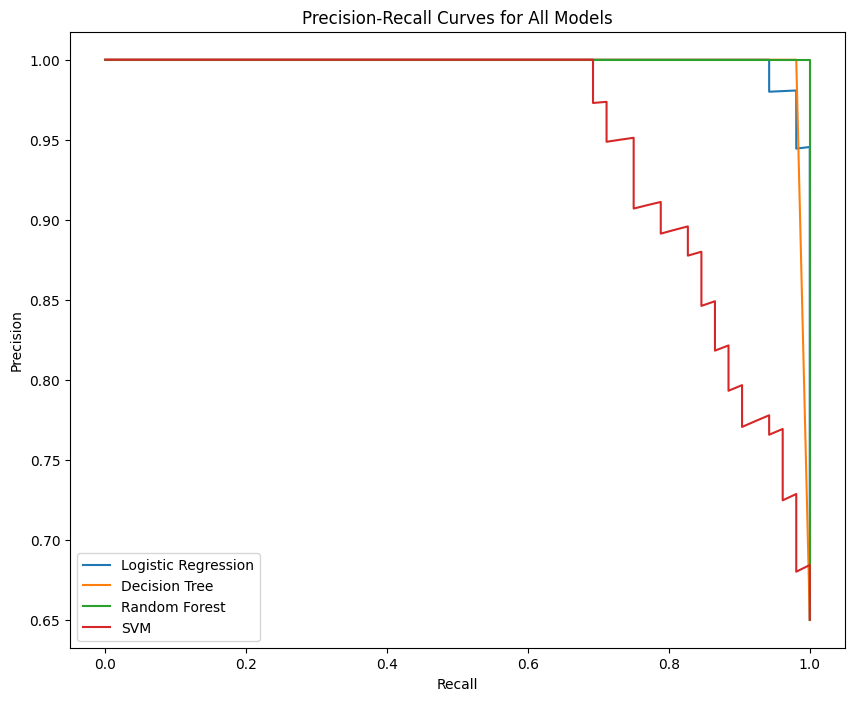

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay

def evaluate_and_plot_results(X_train, X_test, y_train, y_test, models):
    """
    Train models, calculate performance metrics, and plot evaluation results.

    Parameters:
    X_train, X_test, y_train, y_test: Dataset splits
    models (dict): Dictionary of model names and initialized models

    Returns:
    None: Plots accuracy, confusion matrix, ROC curves, and precision-recall curves.
    """
    model_results = {}
    roc_curves = {}
    precision_recall_curves = {}
    accuracies = []

    # Train and evaluate models
    for model_name, model in models.items():
        print(f"Evaluating: {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append((model_name, accuracy))

        # Store confusion matrix
        cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cm_display.ax_.set_title(f"Confusion Matrix: {model_name}")
        plt.show()

        # Store ROC curve data
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_curves[model_name] = (fpr, tpr, roc_auc)

        # Store Precision-Recall curve data
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        precision_recall_curves[model_name] = (precision, recall)

        # Print classification report
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred))

    # Plot accuracies
    plt.figure(figsize=(10, 6))
    accuracies.sort(key=lambda x: x[1], reverse=True)
    model_names, acc_values = zip(*accuracies)
    plt.barh(model_names, acc_values, color="skyblue")
    plt.xlabel("Accuracy")
    plt.ylabel("Models")
    plt.title("Model Accuracy Comparison")
    plt.show()

    # Plot ROC Curves
    plt.figure(figsize=(10, 8))
    for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for All Models")
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curves
    plt.figure(figsize=(10, 8))
    for model_name, (precision, recall) in precision_recall_curves.items():
        plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves for All Models")
    plt.legend(loc="lower left")
    plt.show()


# Call the function
evaluate_and_plot_results(X_train_resampled, X_test, y_train_resampled, y_test, models)



Analyzing feature importance for Logistic Regression...


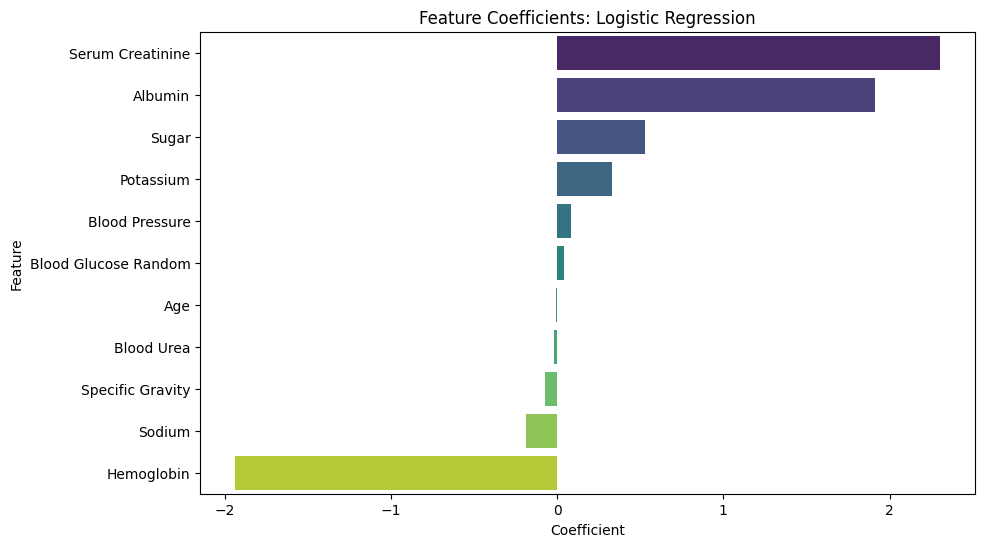


Analyzing feature importance for Decision Tree...


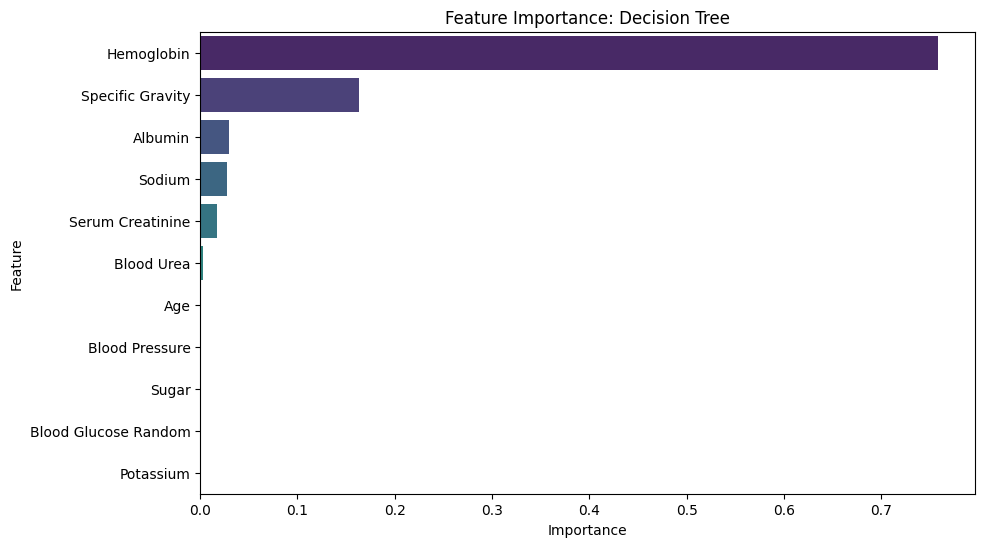


Analyzing feature importance for Random Forest...


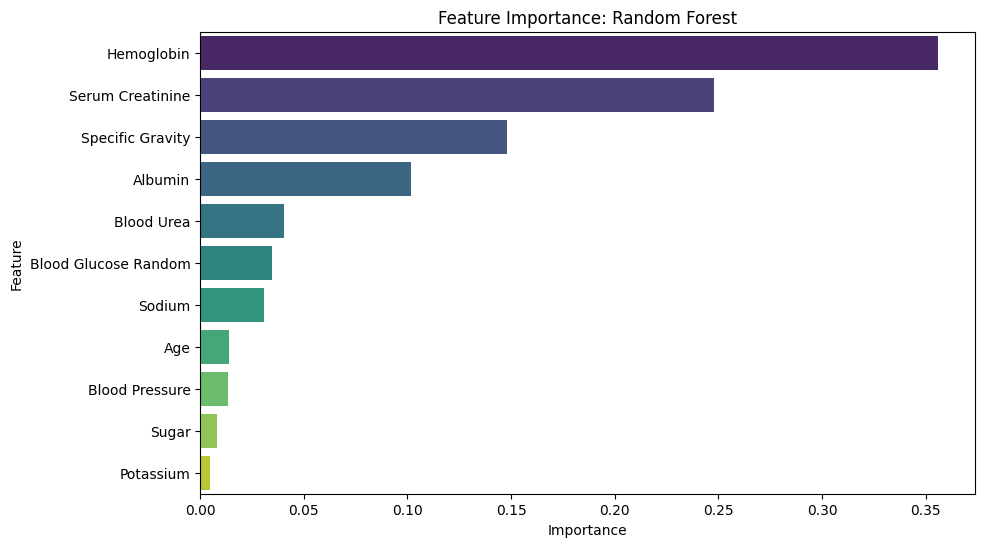


Analyzing feature importance for SVM...
SVM does not support feature importance extraction.


In [77]:
def analyze_feature_importance(models, X):
    """
    Analyze and plot feature importance or coefficients for trained models.

    Parameters:
    models (dict): Dictionary of trained models.
    X (pd.DataFrame): Training features.
    """
    for model_name, model in models.items():
        print(f"\nAnalyzing feature importance for {model_name}...")

        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
            feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

            # Plot feature importance
            plt.figure(figsize=(10, 6))
            sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
            plt.title(f"Feature Importance: {model_name}")
            plt.show()

        elif hasattr(model, "coef_"):
            coefficients = model.coef_[0]
            feature_importance_df = pd.DataFrame({"Feature": X.columns, "Coefficient": coefficients})
            feature_importance_df = feature_importance_df.sort_values(by="Coefficient", ascending=False)

            # Plot coefficients
            plt.figure(figsize=(10, 6))
            sns.barplot(x="Coefficient", y="Feature", data=feature_importance_df, palette="viridis")
            plt.title(f"Feature Coefficients: {model_name}")
            plt.show()

        else:
            print(f"{model_name} does not support feature importance extraction.")

# Call the function
analyze_feature_importance(models, X_train_resampled)


In [78]:
def hyperparameter_tuning(X_train, y_train):
    """
    Perform hyperparameter tuning for Logistic Regression, Decision Tree, Random Forest, and SVM using GridSearchCV.

    Parameters:
    X_train, y_train: Training data and target variable.

    Returns:
    best_models (dict): Dictionary with model names and best models after hyperparameter tuning.
    """
    # Define parameter grids for each model
    param_grids = {
        "Logistic Regression": {
            "C": [0.01, 0.1, 1, 10, 100],
            "solver": ["liblinear", "saga"],
            "penalty": ["l1", "l2"]
        },
        "Decision Tree": {
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        },
        "Random Forest": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        },
        "SVM": {
            "C": [0.1, 1, 10],
            "gamma": ["scale", "auto"],
            "kernel": ["linear", "rbf"]
        }
    }

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42)
    }

    best_models = {}

    # Perform GridSearchCV for each model
    for model_name, model in models.items():
        print(f"Tuning hyperparameters for {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[model_name],
            scoring="accuracy",
            cv=5,
            verbose=1,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_:.4f}")

    return best_models

# Perform hyperparameter tuning
best_models = hyperparameter_tuning(X_train_resampled, y_train_resampled)

# Print the best models
print("\nBest Models After Hyperparameter Tuning:")
for model_name, model in best_models.items():
    print(f"{model_name}: {model}")


Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9798
Tuning hyperparameters for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score for Decision Tree: 0.9772
Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: 0.9950
Tuning hyperparameters for SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best score for SVM: 0.9823

Best Models After Hyperpara

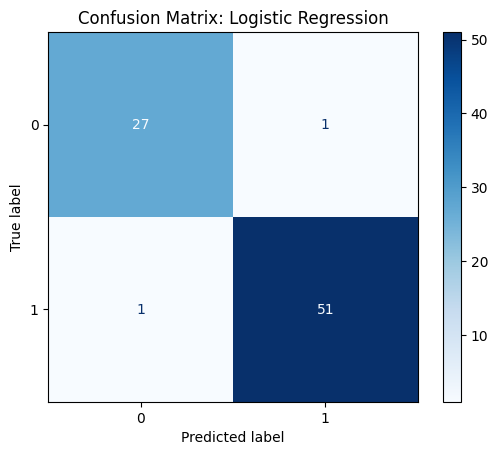

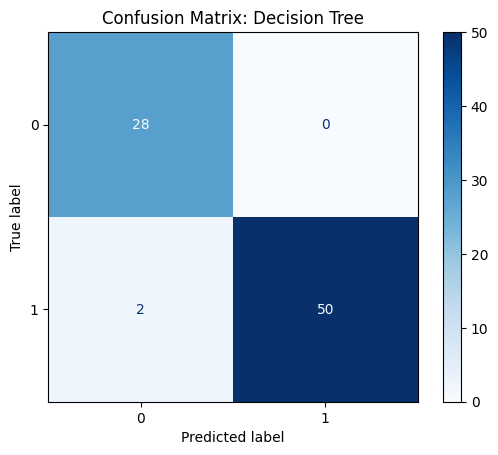

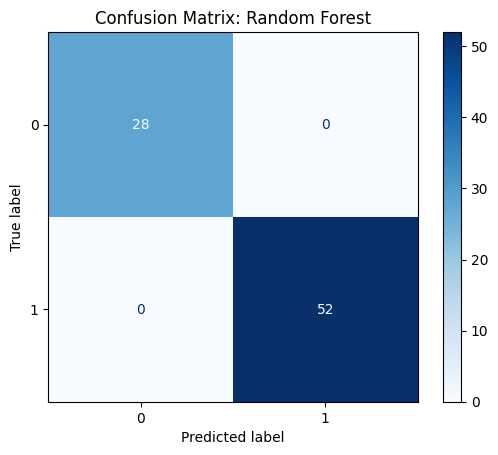

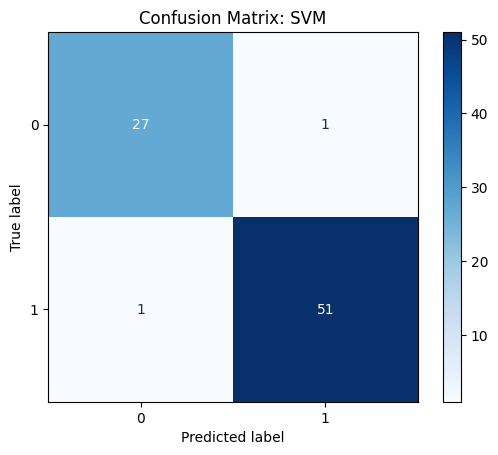

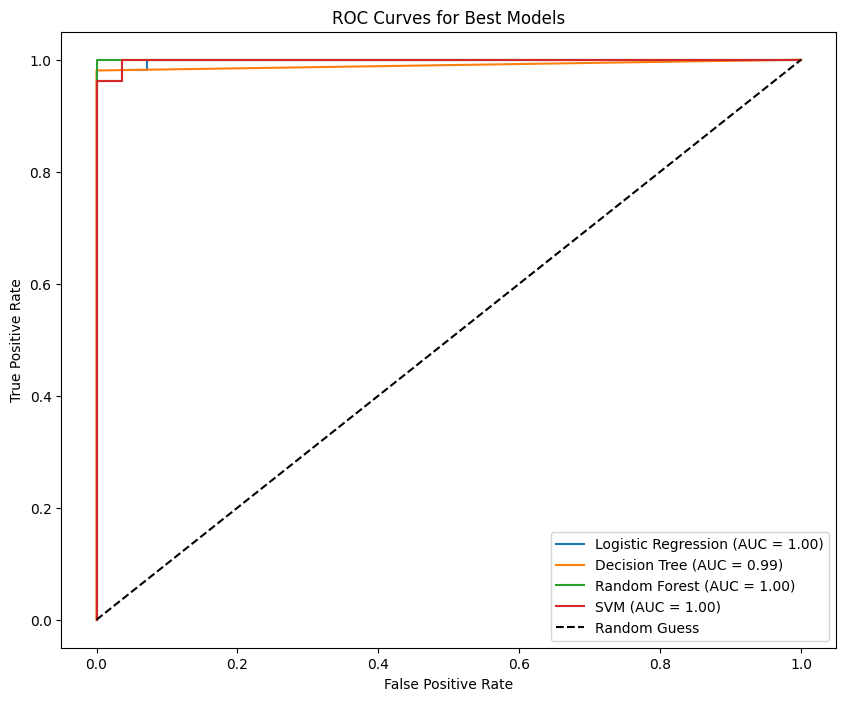

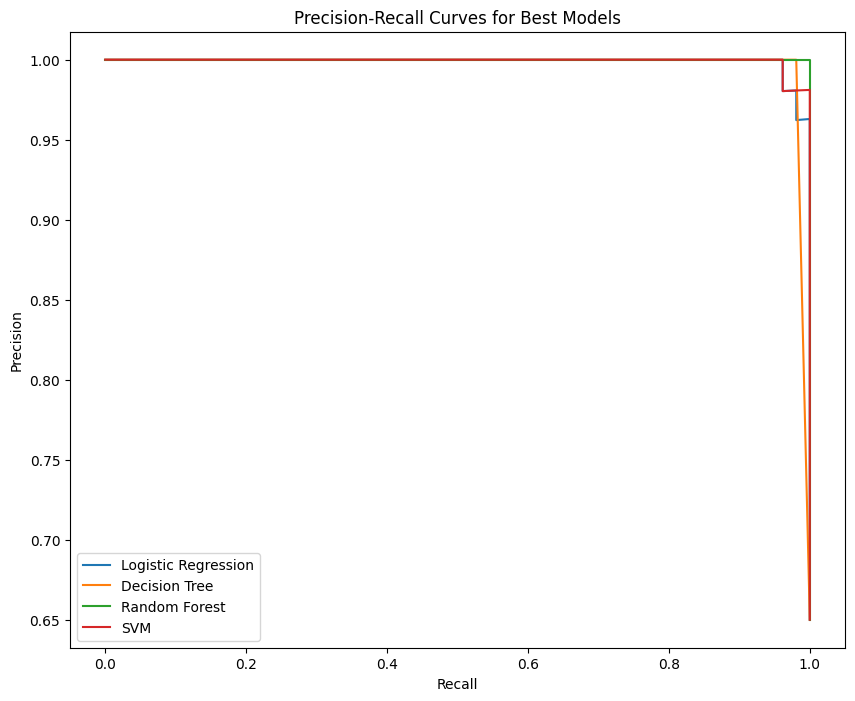

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve

# Function to plot confusion matrices for the best models
def plot_confusion_matrices(best_models, X_test, y_test):
    """
    Plot confusion matrices for the best models.

    Parameters:
    best_models (dict): Dictionary of best models after hyperparameter tuning.
    X_test, y_test: Test dataset and target.
    """
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(cmap='Blues')
        plt.title(f"Confusion Matrix: {model_name}")
        plt.show()

# Function to plot ROC and Precision-Recall curves
def plot_roc_and_precision_curves(best_models, X_test, y_test):
    """
    Plot ROC and Precision-Recall curves for the best models.

    Parameters:
    best_models (dict): Dictionary of best models after hyperparameter tuning.
    X_test, y_test: Test dataset and target.
    """
    # Initialize dictionaries for storing ROC and PR data
    roc_data = {}
    pr_data = {}

    # Generate data for each model
    for model_name, model in best_models.items():
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        roc_data[model_name] = (fpr, tpr, roc_auc)
        pr_data[model_name] = (precision, recall)

    # Plot ROC Curves
    plt.figure(figsize=(10, 8))
    for model_name, (fpr, tpr, roc_auc) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Best Models")
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curves
    plt.figure(figsize=(10, 8))
    for model_name, (precision, recall) in pr_data.items():
        plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves for Best Models")
    plt.legend(loc="lower left")
    plt.show()

# Call the plotting functions
plot_confusion_matrices(best_models, X_test, y_test)
plot_roc_and_precision_curves(best_models, X_test, y_test)


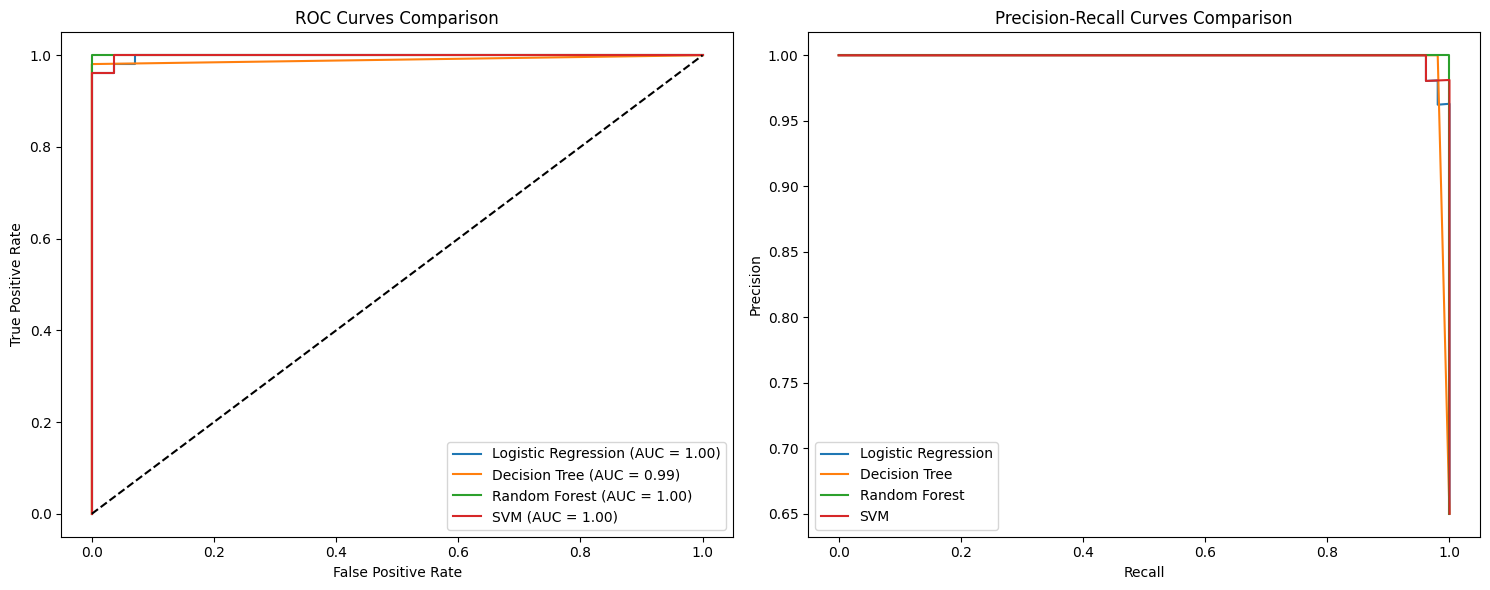

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

def plot_comparison_curves(models, X_test, y_test):
    """
    Plot ROC and Precision-Recall comparison curves for all models.

    Parameters:
    models (dict): Dictionary of trained models.
    X_test (pd.DataFrame): Test features.
    y_test (pd.Series): True labels for the test set.
    """
    # Initialize plot
    plt.figure(figsize=(15, 6))

    # Subplot 1: ROC Curves
    plt.subplot(1, 2, 1)
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    plt.title("ROC Curves Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")

    # Subplot 2: Precision-Recall Curves
    plt.subplot(1, 2, 2)
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision, label=name)
    plt.title("Precision-Recall Curves Comparison")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")

    # Show plots
    plt.tight_layout()
    plt.show()
plot_comparison_curves(best_models, X_test, y_test)